# Silicon Valley Stocks

A lower risk portfolio from silicon valley stocks.

In [183]:
import sys
sys.path.insert(0, '../scripts/')
from database import Stock
import FinanceDatabase as fd
import datetime
start = datetime.datetime(2020,2,1)
end = datetime.date.today()
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline  
plt.style.use('dark_background')
from IPython.core.pylabtools import figsize
figsize(12.0, 8.0)


In [184]:
all_technology_companies = fd.select_equities(sector='Technology')
silicon_valley = fd.search_products(all_technology_companies, query='San Jose', search='city')


for ticker in silicon_valley.copy():
    if '.' in ticker:
        del silicon_valley[ticker]

data_set = {}

for ticker in silicon_valley:
    try:
        data_set[ticker] = Stock(ticker, start, end).df.Close
    except Exception:
        continue
tmp_data= pd.concat(data_set, axis=1)
assets = list(tmp_data.columns)             

Select 10 stocks from our asset list

In [185]:
stk_set = {}
asset=assets[0:10]
for ticker in asset:
    stk_set[ticker]= Stock(ticker, start, end).df.Close
hist_data = pd.concat(stk_set, axis=1)

<AxesSubplot:xlabel='Date'>

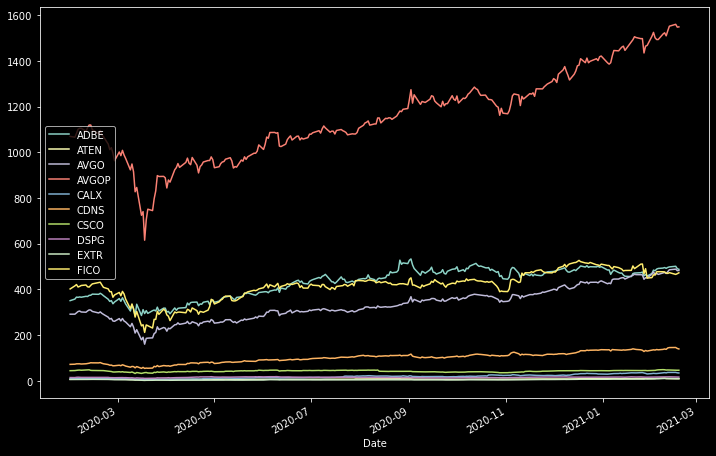

In [186]:
hist_data.plot()

array([[<AxesSubplot:title={'center':'ADBE'}>,
        <AxesSubplot:title={'center':'ATEN'}>,
        <AxesSubplot:title={'center':'AVGO'}>],
       [<AxesSubplot:title={'center':'AVGOP'}>,
        <AxesSubplot:title={'center':'CALX'}>,
        <AxesSubplot:title={'center':'CDNS'}>],
       [<AxesSubplot:title={'center':'CSCO'}>,
        <AxesSubplot:title={'center':'DSPG'}>,
        <AxesSubplot:title={'center':'EXTR'}>],
       [<AxesSubplot:title={'center':'FICO'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

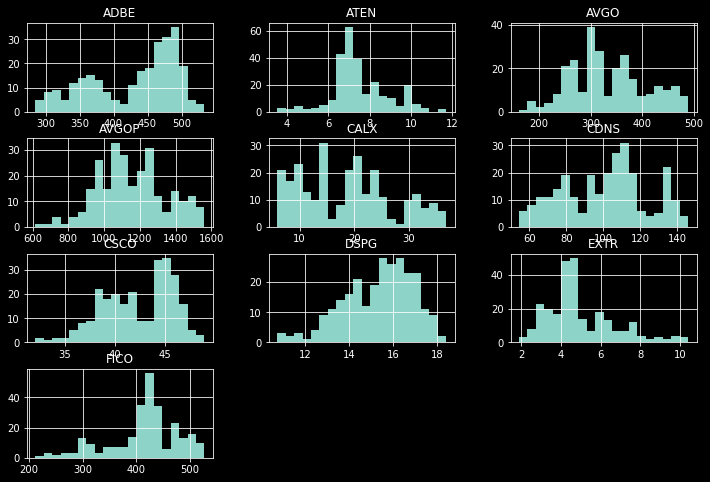

In [187]:
hist_data.hist(bins=20)

In [188]:
returns = np.log(hist_data/hist_data.shift(1))

In [189]:
returns.mean()

ADBE     0.001250
ATEN     0.001139
AVGO     0.001911
AVGOP    0.001402
CALX     0.005018
CDNS     0.002500
CSCO     0.000161
DSPG     0.000477
EXTR     0.001864
FICO     0.000613
dtype: float64

In [190]:
returns.mean().mean()

0.0016334496388459567

In [191]:
# the objective function is to minimize the portfolio risk
def objective(weights): 
    weights = np.array(weights)
    return weights.dot(returns.cov()).dot(weights.T)

# The constraints
cons = (# The weights must sum up to one.
        {"type":"eq", "fun": lambda x: np.sum(x)-1}, 
        # This constraints says that the inequalities (ineq) must be non-negative.
        # The expected daily return of our portfolio and we want to be at greater than 0.003
        {"type": "ineq", "fun": lambda x: np.sum(returns.mean()*x)-0.003}) 
 
# Every stock can get any weight from 0 to 1
bounds = tuple((0,1) for x in range(returns.shape[1])) 
 
# Initialize the weights with an even split
# In out case each stock will have 10% at the beginning
guess = [1./returns.shape[1] for x in range(returns.shape[1])]
optimized_results = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)
optimized_results

     fun: 0.0008812708294176578
     jac: array([0.00131659, 0.00131298, 0.00157322, 0.0011653 , 0.00246636,
       0.00137919, 0.00093763, 0.00103352, 0.00199759, 0.00169465])
 message: 'Optimization terminated successfully'
    nfev: 88
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([8.05500937e-02, 4.83233942e-02, 1.18652417e-01, 1.13865091e-01,
       3.75095852e-01, 2.25025795e-01, 1.63042273e-02, 2.21831306e-02,
       1.38777878e-17, 2.31883740e-17])

In [192]:
optimized_results.x

array([8.05500937e-02, 4.83233942e-02, 1.18652417e-01, 1.13865091e-01,
       3.75095852e-01, 2.25025795e-01, 1.63042273e-02, 2.21831306e-02,
       1.38777878e-17, 2.31883740e-17])

In [193]:
np.sum(optimized_results.x)

1.0

In [194]:
np.sum(returns.mean()*optimized_results.x)

0.0029999999999631008

In [195]:
pd.DataFrame(list(zip(assets, optimized_results.x)), columns=['Symbol', 'Weight'])

,Symbol,Weight
0,ADBE,8.055009e-02
1,ATEN,4.832339e-02
2,AVGO,1.186524e-01
3,AVGOP,1.138651e-01
4,CALX,3.750959e-01
5,CDNS,2.250258e-01
6,CSCO,1.630423e-02
7,DSPG,2.218313e-02
8,EXTR,1.387779e-17
9,FICO,2.318837e-17


In [196]:
weight = optimized_results.x
r = returns 
t = np.sum(weight)
W = weight/t
wp = np.dot(r, W)
port_ret = pd.DataFrame({'daily_log_return': wp})
port_ret.index = r.index

<AxesSubplot:xlabel='Date'>

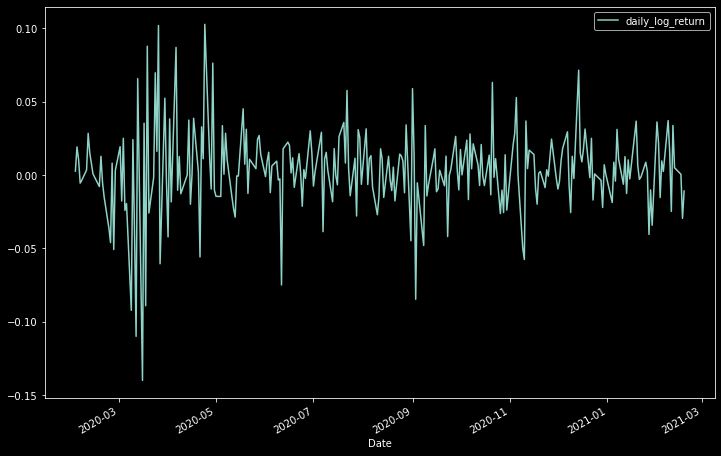

In [197]:
port_ret.plot()

In [198]:
def cumulative_wealth_plot(x):
    return ((1*x+1).cumprod()-1).plot(figsize = (15, 6), title='Cumulative Wealth');

<AxesSubplot:title={'center':'Cumulative Wealth'}, xlabel='Date'>

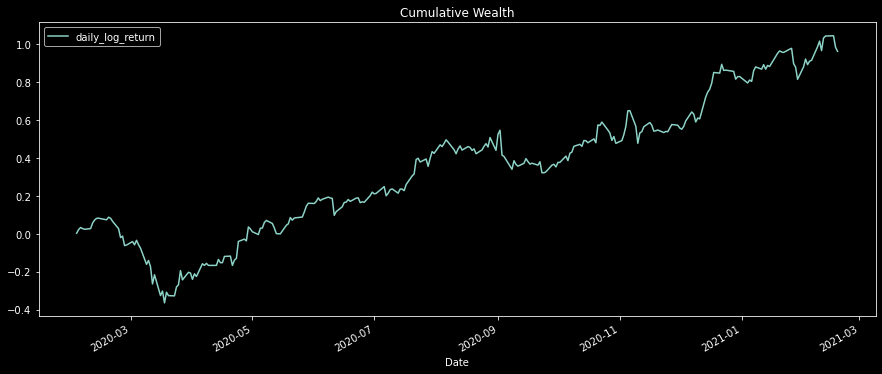

In [199]:
cumulative_wealth_plot(port_ret)